In [1]:
import numpy as np
from scipy.optimize import minimize
from xmps.spin import U4
from scipy.stats import unitary_group
from scipy.linalg import eig

X = np.array([
    [0,1],
    [1,0]
])

Z = np.array([
    [1,0],
    [0,-1]
])

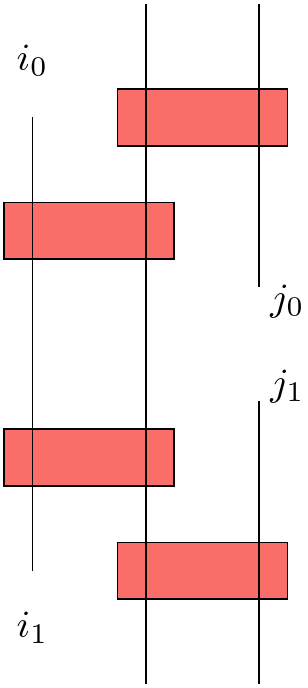

In [2]:
def ShiftedState(U1, U2):
    """
    Make a state B[d,i,j] = Σₐ U2[0,1,2,a]U1[a,4,5,6]
    """
    return np.tensordot(U2.reshape(2,2,2,2),U1.reshape(2,2,2,2),(3,0))[...,0,0].reshape(4,2,2)


def MixedTransfer(A, B):
    contracted = np.tensordot(          # A[a,0i,1j]B'[a,2i,3j]
                        A,              # first tensor  
                        B.conj(),       # second tensor
                        (0,0)
                    )
    return np.transpose(contracted, (0,2,1,3)).reshape(4,4)

def State(U1, U2):
    """
    Make a state A[d,i,j] = Σₐ U2[0,1,a,2]U1[3,a,4,5]
    """
    return np.tensordot(
        U2.reshape(2,2,2,2), 
        U1.reshape(2,2,2,2),
        (2,1)
    )[...,0,0].reshape(4,2,2)

 
U2 = np.eye(4)
U1 = np.eye(4)

x = MixedTransfer(ShiftedState(U1, U2), ShiftedState(np.eye(4), np.eye(4)))

η,v = eig(x)
print(η)
print(v)
    

[0.+0.j 1.+0.j 0.+0.j 0.+0.j]
[[0.         0.70710678 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [1.         0.70710678 0.         0.        ]]


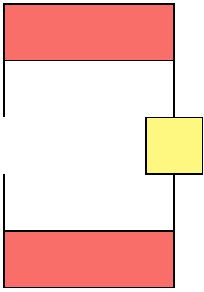

In [3]:
def RightEnv(U1,U1_, M):
    return np.einsum(
        U1_[0,:].reshape(2,2), [0,1], 
        M,                     [1,2],
        U1[:,0].reshape(2,2),  [3,2],
        [3,0]
    )

In [4]:
U1 = np.eye(4)
M = np.eye(2) / np.sqrt(2)

RightEnv(U1, U1, M)

array([[0.70710678, 0.        ],
       [0.        , 0.        ]])

In [5]:
def RightEnvironment(U1, U2, U1_, U2_):
    
    TM = MixedTransfer(
        ShiftedState(U1, U2),
        ShiftedState(U1_, U2_)
    )
    
    η, v = eig(TM)
    Mr = v[:,np.argmax(np.abs(η))].reshape(2,2)
    
    Re = RightEnv(U1, U1.conj().T, Mr)
    
    return Re / np.linalg.norm(Re)

In [6]:
U1 = U2 = U1_ = U2_ = np.eye(4)
print(RightEnvironment(U1,U2,U1_,U2_))

[[1. 0.]
 [0. 0.]]


In [7]:
def LeftEnv(U1, U2, U1_, U2_):
    TM = MixedTransfer(
        State(U1, U2),
        State(U1_, U2_)
    )
    
    η, v = eig(TM.T)
    Ml = v[:,np.argmax(np.abs(η))].reshape(2,2)
    
    return Ml


In [8]:
LeftEnv(*[np.eye(4)]*4)

array([[1., 0.],
       [0., 0.]])

In [12]:
def Double(A):
    """
    Return AA =Σₐ A[d0,i0,a]A[d1, a, j1]
    """
    return np.transpose(np.tensordot(A,A,(2,1)), (0,2,1,3)).reshape(16,2,2)

x0 = np.random.rand(30)
U1, U2 = [U4(x0[:15]), U4(x0[15:])]

def Overlap(U1, U2, U1_, U2_):
    A = State(U1,U2)
    A_ = State(U1_,U2_)

    DMT = MixedTransfer(Double(A), Double(A_))

    RE = RightEnvironment(U1, U2, U1_, U2_).reshape(4,)
    LE = LeftEnv(U1, U2, U1_, U2_).reshape(4,)

    Score = LE.T @ DMT @ RE

    return -np.real(Score)

def cost_func(p, U1, U2):
    U1_, U2_ = U4(p[:15]), U4(p[15:])
    return Overlap(U1, U2, U1_, U2_)

res = minimize(cost_func, x0 = x0,args = (U1,U2), method = "Nelder-Mead")
    
    
    

In [22]:
U = unitary_group.rvs(4)
print(RightEnvironment(*[U]*4))
print(Overlap(*[U]*4))

[[ 0.36436999+6.11797975e-25j -0.09256412-2.57398790e-01j]
 [-0.09256412+2.57398790e-01j  0.84710684-1.49094906e-24j]]
-0.7349834528406427


In [15]:
res.x

array([ 0.39229928,  0.0048856 ,  2.09733577,  0.36886468, -1.32029123,
       -0.851567  ,  0.17918258, -0.63921618,  0.56651008,  1.19021442,
        0.15528996,  0.09341715,  0.0784685 ,  0.1907506 , -0.00508295,
        0.43773499,  0.24563017,  0.22260694,  0.33648461,  0.05462223,
       -0.48930131,  1.3640746 ,  0.68787361,  0.12287264,  1.35742926,
       -1.06164355,  0.60685608, -0.35602494, -0.22646868,  0.43435452])